In [1]:
import csv
import numpy as np
from queue import SimpleQueue

In [2]:
lst = []
with open('matchstat.csv', 'rt') as file:
    cr = csv.DictReader(file)
    for row in cr:
        lst.append(row)
lst_classified_in_matches = []
ok = {}
for row in lst:
    match_name = row['match_id']
    if match_name in ok:
        continue
    ok[match_name] = True
    lst_4_this_match = [row for row in lst if row['match_id'] == match_name]
    lst_classified_in_matches.append(lst_4_this_match)

In [27]:
# IMPORTANT: all calculations are based on the status INCLUDING the result of the current point

def calc_for_serve(match, player, f): # calculates the statistics for last three serves
    ret = []
    Q = SimpleQueue()
    Q_len = 0
    tot = 0
    for row in match:
        server = row['server']
        if server == player:
            flag = f(row, player)
            Q.put(flag)
            Q_len += 1
            tot += flag
            if Q_len > 3:
                tot -= Q.get()
                Q_len -= 1
        ret.append(0 if Q_len == 0 else tot / Q_len)
    return ret

def calc_for_strike(match, player, f): # calculating statistics for strikes
    ret = []
    Q = SimpleQueue()
    Q_len = 0
    tot = 0
    for row in match:
        flag = f(row, player)
        Q.put(flag)
        Q_len += 1
        tot += flag
        if Q_len > 3:
            tot -= Q.get()
            Q_len -= 1
        ret.append(tot / Q_len)
    return ret

def calc_net_rate(match, player):
    ret = []
    Q1 = SimpleQueue()
    Q2 = SimpleQueue()
    Q_len = 0
    tot = 0
    wins = 0
    for row in match:
        flag1 = 1 if row['p' + player + '_net_pt'] == '1' else 0
        flag2 = 1 if row['p' + player + '_net_pt_won'] == '1' else 0
        Q1.put(flag1)
        Q2.put(flag2)
        Q_len += 1
        tot += flag1
        wins += flag2
        if Q_len > 3:
            tot -= Q1.get()
            wins -= Q2.get()
            Q_len -= 1
        ret.append(0 if tot == 0 else wins / tot)
    return ret

def calc_for_this_strike(match, player, f): # statistics for this strike
    return [f(row, player) for row in match]

def calc_score_diff(match, player):
    ret = []
    Q = SimpleQueue()
    diff = 0
    cur_game = 0
    # Q_len = 0
    for row in match:
        game_no = int(row['game_no'])
        if cur_game != game_no:
            cur_game = game_no
            diff = 0
            while not Q.empty():
                Q.get()
            # Q_len = 0
        flag = (1 if row['point_victor'] == player else -1)
        Q.put(flag)
        # Q_len += 1
        diff += flag
        ret.append(diff / 3)
    return ret

def proc_match(match, player, output_file):

    # serve
    ace = calc_for_serve(match, player, lambda row, player: int(row['p' + player + '_ace']))
    double_fault = calc_for_serve(match, player, lambda row, player: -int(row['p' + player + '_double_fault']))
    first_serve = calc_for_serve(match, player, lambda row, _: (2 - int(row['serve_no'])))
    fast_win = calc_for_serve(match, player, lambda row, player: (1 if (int(row['rally_count']) <= 3 and row['point_victor'] == player) else 0))
    return_depth = calc_for_serve(match, ('1' if player == '2' else '2'), lambda row, _: (-1 if row['return_depth'] == 'NA' else (0 if row['return_depth'] == 'ND' else 1))) # 对手发球

    # strike
    winner = calc_for_strike(match, player, lambda row, player: int(row['p' + player + '_winner']))
    net_win_rate = calc_net_rate(match, player)

    # fatigue
    distance = calc_for_this_strike(match, player, lambda row, player: (-1 if float(row['p' + player  + '_distance_run']) > 45 else (0 if float(row['p' + player  + '_distance_run']) < 5 else (-float(row['p' + player  + '_distance_run']) - 5) / 40)))
    unforced_error = calc_for_strike(match, player, lambda row, player: -int(row['p' + player + '_unf_err']))
    rally = calc_for_this_strike(match, player, lambda row, _: (-1 if int(row['rally_count']) > 10 else -(int(row['rally_count']) - 1) / 9))

    # mindset
    scored_last_point = calc_for_this_strike(match, player, lambda row, player: (1 if row['point_victor'] == player else 0))
    score_diff = calc_score_diff(match, player)

    with open(output_file, 'w') as f:
        writer = csv.writer(f)

        writer.writerow(['ace', 'double_fault', 'first_serve', 'fast_win', 'return_depth', 'winner', 'net_win_rate', 'distance', 'unforced_error', 'rally', 'scored_last_point', 'score_diff'])
        for i in range(len(match)):
            writer.writerow([ace[i], double_fault[i], first_serve[i], fast_win[i], return_depth[i], winner[i], net_win_rate[i], distance[i], unforced_error[i], rally[i], scored_last_point[i], score_diff[i]])
        
        f.close()

    

# proc_match(lst_classified_in_matches[0], '1', 'test.csv')

# arr = calc_for_serve(lst_classified_in_matches[0], '1', lambda row, player: int(row['p' + player + '_ace']))
# arr2 = [int(row['p1_ace']) for row in lst_classified_in_matches[0]]
# arr3 = [int(row['server']) for row in lst_classified_in_matches[0]]
# print(arr)
# print(arr2)
# print(arr3)

for cur_match in lst_classified_in_matches:
    match_name = cur_match[0]['match_id']
    proc_match(cur_match, '1', './data/' + match_name + '-player1.csv')
    proc_match(cur_match, '2', './data/' + match_name + '-player2.csv')

In [16]:


def f(score_diff_serve, score_diff_receive, last_game_res, consec_win, is_server):
    if is_server:
        return 0.5656 * score_diff_serve + 0.0618 * score_diff_receive + 0.1728 * last_game_res + 0.1998 * consec_win
    else:
        return 0.5656 * score_diff_receive + 0.0618 * score_diff_serve + 0.1728 * last_game_res + 0.1998 * consec_win


def calcMomentum(match, player, window):
    pts_count = len(match)
    score_diff = [1 if point['point_victor'] == player else -1 for point in match]
    score_diff_serve = []
    score_diff_receive = []
    last_game_res = []
    consec_win = []
    sv = 0
    rc = 0
    for i in range(pts_count):
        point = match[i]
        server = point['server']
        if server == player:
            score_diff_serve.append((0 if sv == 0 else score_diff_serve[sv - 1]) + score_diff[i])
            sv += 1
        else:
            score_diff_receive.append((0 if rc == 0 else score_diff_receive[rc - 1]) + score_diff[i])
            rc += 1
        last_game_res.append(False if i == 0 else (last_game_res[i - 1] if point['game_victor'] == 0 else (point['game_victor'] == player)))
        consec_win.append(0 if point['point_victor'] != player else (0 if i == 0 else consec_win[i - 1]) + 1)
        consec_win[i] = min(consec_win[i], window)
    ret = []
    sv = 0
    rc = 0
    for i in range(pts_count):
        point = match[i]
        server = point['server']
        if server == player:
            sv += 1
        else:
            rc += 1
        serve_param = 0 if sv == 0 else (score_diff_serve[sv - 1] - (0 if sv < window else score_diff_serve[sv - window]))
        receive_param = 0 if rc == 0 else (score_diff_receive[rc - 1] - (0 if rc < window else score_diff_receive[rc - window]))
        ret.append(f((serve_param + window) / window, (receive_param + window) / window, 1 if last_game_res[i] else 0, consec_win[i] / window, (server == player)))
    return ret
momentum = calcMomentum(lst4match1[0: 10], '1', 5)

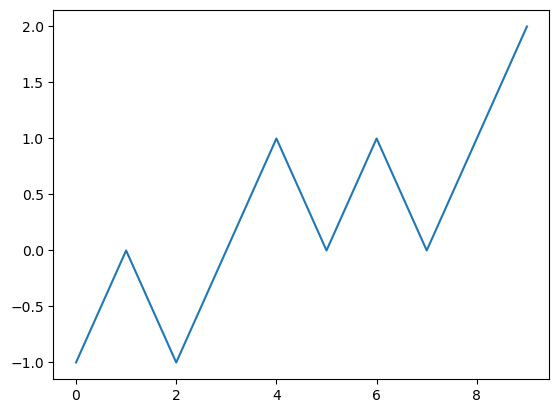

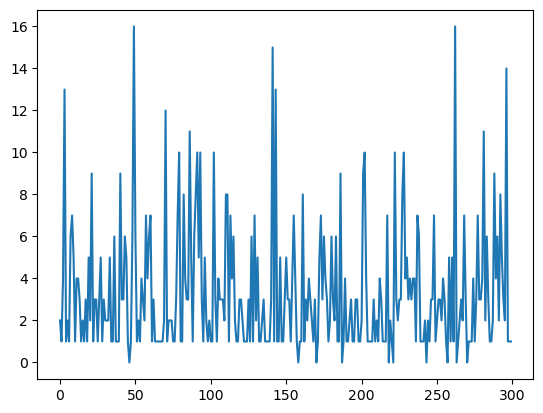

In [24]:
import matplotlib.pyplot as plt
plt.plot(tot[0: 10])
plt.show()
plt.plot(p1_dist)
plt.show()